# Using LogProbs to find correct sentence placement

We come up with a hypothesis that examining logprob could be used as a mechanism to get the sentence and outline to match. We are going to test this hypothesis by analyzing logprob values with different iterations of sentence orders and seeing if when the outline and sentence are correctly matched, we get the highest logprob.

Setup notebook with correct imports

In [1]:
import os
import openai
openai.organization = "org-9bUDqwqHW2Peg4u47Psf9uUo"
openai.api_key = os.environ.get("OPENAI_API_KEY")
openai.Model.list()

<OpenAIObject list at 0x7fa2195e3b30> JSON: {
  "data": [
    {
      "created": 1649358449,
      "id": "babbage",
      "object": "model",
      "owned_by": "openai",
      "parent": null,
      "permission": [
        {
          "allow_create_engine": false,
          "allow_fine_tuning": false,
          "allow_logprobs": true,
          "allow_sampling": true,
          "allow_search_indices": false,
          "allow_view": true,
          "created": 1669085501,
          "group": null,
          "id": "modelperm-49FUp5v084tBB49tC4z8LPH5",
          "is_blocking": false,
          "object": "model_permission",
          "organization": "*"
        }
      ],
      "root": "babbage"
    },
    {
      "created": 1649359874,
      "id": "davinci",
      "object": "model",
      "owned_by": "openai",
      "parent": null,
      "permission": [
        {
          "allow_create_engine": false,
          "allow_fine_tuning": false,
          "allow_logprobs": true,
          "allow_sa

Next, we give our prompt to the model and put it in variable: qo_1

In [49]:
qo_1 = '''
Write a short essay given this outline:
• Caught travel bug at age 5 when grandparents brought to France 
• Visited 29 countries
• Experienced the Eiffel Tower in Paris at age 5
• Fed pigeons in Piazza San Marco at age 8
• Saw Stonehenge at age 13
• Walked the Great Wall of China at age 13
\n
'''

Below is the paragraph we want to find the logprob of, given the prompt we have in the variable, qo_1

In [50]:
sentences_1 = [
    'When I was very little, I caught the travel bug. ',
    'It started after my grandparents first brought me to their home in France and I have now been to twenty-nine different countries. ',
    'Each has given me a unique learning experience. ',
    'At five, I marveled at the Eiffel Tower in the City of Lights. ',
    'When I was eight, I stood in the heart of Piazza San Marco feeding hordes of pigeons, then glided down Venetian waterways on sleek gondolas. ',
    'At thirteen, I saw the ancient, megalithic structure of Stonehenge and walked along the Great Wall of China, amazed that the thousand-year-old stones were still in place. '
]

Below is a function that moves a specific sentence in every position possible to create different iterations of the paragraph.

In [51]:
def all_unique_pos(lst, element):
    res = []
    for i in range(len(lst)):
        new_list = lst[:]
        new_list.pop(lst.index(element))
        res.append(new_list[:i] + [element] + new_list[i:])
    return res

We start with moving the first sentence in every position and save it into combinations

In [52]:
combinations = all_unique_pos(sentences_1, sentences_1[0])
combinations

[['When I was very little, I caught the travel bug. ',
  'It started after my grandparents first brought me to their home in France and I have now been to twenty-nine different countries. ',
  'Each has given me a unique learning experience. ',
  'At five, I marveled at the Eiffel Tower in the City of Lights. ',
  'When I was eight, I stood in the heart of Piazza San Marco feeding hordes of pigeons, then glided down Venetian waterways on sleek gondolas. ',
  'At thirteen, I saw the ancient, megalithic structure of Stonehenge and walked along the Great Wall of China, amazed that the thousand-year-old stones were still in place. '],
 ['It started after my grandparents first brought me to their home in France and I have now been to twenty-nine different countries. ',
  'When I was very little, I caught the travel bug. ',
  'Each has given me a unique learning experience. ',
  'At five, I marveled at the Eiffel Tower in the City of Lights. ',
  'When I was eight, I stood in the heart of Pi

We simply get the original text by joining all the sentences in the list sentences_1 together, giving us our truth value (i.e. the correct positions of sengtences to match with the outline). For this sentence order, we expect our logprob value to be the highest if we are to go along with our hypothesis.

In [53]:
original_text = ''.join(sentences_1)
original_text

'When I was very little, I caught the travel bug. It started after my grandparents first brought me to their home in France and I have now been to twenty-nine different countries. Each has given me a unique learning experience. At five, I marveled at the Eiffel Tower in the City of Lights. When I was eight, I stood in the heart of Piazza San Marco feeding hordes of pigeons, then glided down Venetian waterways on sleek gondolas. At thirteen, I saw the ancient, megalithic structure of Stonehenge and walked along the Great Wall of China, amazed that the thousand-year-old stones were still in place. '

We create a function to join the question and outline with the sentences to get a full prompt that will be given to the API to find the logprob.

In [54]:
def full_request_template(question, sents):
    return question + ''.join(sents)

After this, we now use our full_request_template function to join the prompt with the base outline which is stored in the qo_1 variable and the sentence iteration which is stored in sentences_1 variable. We store the result in the request variable.

In [55]:
#request = full_request_template(qo_1, sentences_1)
#request

We add a function to cache the memory of the functions we run so that we don't have to query the api the same way again everytime we run this notebook.

In [56]:
import joblib
from joblib import Memory
import os

home_dir = os.path.expanduser("~")
cache_dir = os.path.join(home_dir, ".joblib_cache")
memory = Memory(cache_dir, verbose=0)

@memory.cache
def get_response(full_request):
  response = openai.Completion.create(
      model="text-davinci-003",
      prompt = full_request,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      logprobs=10,
      echo=True
    )
  return response

This function gives us the API response for our request to the API and stores it in a list

In [57]:
def get_all_responses(options):
    response = []
    for x in options:
        response.append(get_response(full_request_template(qo_1, x)))
    return response


    

We create a variable result and store the response of the different sentence iterations in the list combinations.

In [58]:
result = get_all_responses(combinations)
result

[<OpenAIObject text_completion id=cmpl-6s5yt9Q0yJrhUPceKMv5QimJmuQEC at 0x7fe1eac6d5e0> JSON: {
   "choices": [
     {
       "finish_reason": "stop",
       "index": 0,
       "logprobs": {
         "text_offset": [
           0,
           1,
           6,
           8,
           14,
           20,
           26,
           31,
           39,
           40,
           41,
           42,
           44,
           49,
           56,
           60,
           63,
           67,
           69,
           74,
           87,
           95,
           98,
           105,
           106,
           107,
           108,
           112,
           116,
           119,
           129,
           130,
           131,
           137,
           143,
           147,
           149,
           152,
           154,
           160,
           163,
           169,
           172,
           176,
           178,
           179,
           180,
           184,
           189,
           192,
          

Below we have to come up with a function to compute logprobs of the various sentence iterations in our responses list. We should remember that our request to the API starts wioth the question and the outline, but we just want to find the logprob of the text (which is all the sentences joined together to give us a paragraph). In order to do this we perform a few calculations to make suure that our text offset of calculating the logprob starts exactly from where the paragraph starts, leaving the prompt (the question and outline) out of the logprob calculation.

In [59]:
def compute_log_probs(question_w_outline, original_text, response):
    # Get start and end points
    start_point = len(question_w_outline)
    end_point = start_point + len(original_text)
    
    # Get start and end indices
    text_offsets = response.choices[0].logprobs.text_offset
    start_index = text_offsets.index(start_point)
    end_index = text_offsets.index(end_point)
    
    # Compute total log probabilities
    token_logprobs = response.choices[0].logprobs.token_logprobs
    total_logprobs = sum(token_logprobs[start_index:end_index+1])
    
    return total_logprobs

Now we want to find the logprobs of the different sentence iterations in the combinations list. This will produce us a list with various logprob values. Looking at the list, we notice that the highest logprob value corresponds to the original text arrangement which is consistent to our hypothesis that the more the sentences match with the outline, the higher the logprob value.

In [60]:
pairs = ()
logprobs_1 = []
for i in range(len(combinations)):
    original_text = ''.join(combinations[i])
    logprobs_1.append(compute_log_probs(qo_1, original_text, result[i]))

logprobs_1

[-235.83677383316822,
 -257.78185305795677,
 -247.23005410289977,
 -256.5735687438675,
 -260.9305617790358,
 -254.19583013342478]

The code below produces a visual representation of the logprobs of these various paragraph iterations following the original outline

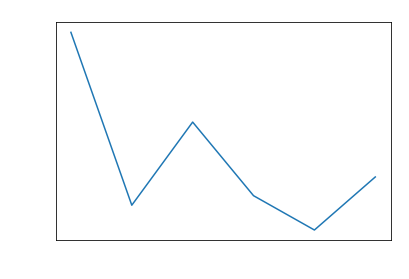

In [61]:
import matplotlib.pyplot as plt

# Plot the logprobs list
plt.plot(logprobs_1)

# Set the title and axis labels
plt.title('Logprobs Plot', color='white')
plt.xlabel('Iterations', color='white')
plt.ylabel('Logprobs', color='white')

# Set the tick labels on the x axis
x_ticks = ['Iteration_{}'.format(i+1) for i in range(len(logprobs_1))]
plt.xticks(range(len(logprobs_1)), x_ticks)

# Set the color of the frame, ticks and labels to white
frame = plt.gca()
frame.tick_params(axis='x', colors='white')
frame.tick_params(axis='y', colors='white')

# Show the plot
plt.show()

We can now see a visual representation of the different iterations and their corresponding logprobs but we can't really see the sentence orders in the different iterations. Let's take a look at this and see whether, the outline corresponding to the correct sentence order gets the highest logprob value. In this case, Iteration 1 has the highest logprob which is the second list in the nested list.

In [62]:
combinations

[['When I was very little, I caught the travel bug. ',
  'It started after my grandparents first brought me to their home in France and I have now been to twenty-nine different countries. ',
  'Each has given me a unique learning experience. ',
  'At five, I marveled at the Eiffel Tower in the City of Lights. ',
  'When I was eight, I stood in the heart of Piazza San Marco feeding hordes of pigeons, then glided down Venetian waterways on sleek gondolas. ',
  'At thirteen, I saw the ancient, megalithic structure of Stonehenge and walked along the Great Wall of China, amazed that the thousand-year-old stones were still in place. '],
 ['It started after my grandparents first brought me to their home in France and I have now been to twenty-nine different countries. ',
  'When I was very little, I caught the travel bug. ',
  'Each has given me a unique learning experience. ',
  'At five, I marveled at the Eiffel Tower in the City of Lights. ',
  'When I was eight, I stood in the heart of Pi

From this, the sentence iteration that we expected to give us our highest logprob actually gives us the highest logprob showing us that the more correct the sentence alignment is with the outline, the higher the logprob.

Now let's try and see whether in computing the logprobs, the API actually pays attention to the outline order

We will first start with shuffling the outline order this time, instead of the sentence order, and in this case our true value will be the sentence order.

To make things easier, we will just use the all_unique_pos() function we created earlier, but this time to move the one outline around in different positions instead of the sentences.

In [63]:
outline = [
    '• Caught travel bug at age 5 when grandparents brought to France\n',
    '• Visited 29 countries\n',
    '• Experienced the Eiffel Tower in Paris at age 5\n',
    '• Fed pigeons in Piazza San Marco at age 8\n',
    '• Saw Stonehenge at age 13\n',
    '• Walked the Great Wall of China at age 13\n'
    
]

In [64]:
combinations_outline = [['Write a short essay given this outline:\n'] + x for x in all_unique_pos(outline, outline[0])]
combinations_outline

[['Write a short essay given this outline:\n',
  '• Caught travel bug at age 5 when grandparents brought to France\n',
  '• Visited 29 countries\n',
  '• Experienced the Eiffel Tower in Paris at age 5\n',
  '• Fed pigeons in Piazza San Marco at age 8\n',
  '• Saw Stonehenge at age 13\n',
  '• Walked the Great Wall of China at age 13\n'],
 ['Write a short essay given this outline:\n',
  '• Visited 29 countries\n',
  '• Caught travel bug at age 5 when grandparents brought to France\n',
  '• Experienced the Eiffel Tower in Paris at age 5\n',
  '• Fed pigeons in Piazza San Marco at age 8\n',
  '• Saw Stonehenge at age 13\n',
  '• Walked the Great Wall of China at age 13\n'],
 ['Write a short essay given this outline:\n',
  '• Visited 29 countries\n',
  '• Experienced the Eiffel Tower in Paris at age 5\n',
  '• Caught travel bug at age 5 when grandparents brought to France\n',
  '• Fed pigeons in Piazza San Marco at age 8\n',
  '• Saw Stonehenge at age 13\n',
  '• Walked the Great Wall of C

The outline_1 variable simply contains the jumbled up version of the question with outline (the outlines are jumbled up here). We jumble up the outline, as stated earlier, just so that we can compare that to the outline that isn't jumbled to see whether the API request when calculating the logprobs takes into account the outline order.


In [65]:
outline_1 = ''.join(combinations_outline[2])
outline_1

'Write a short essay given this outline:\n• Visited 29 countries\n• Experienced the Eiffel Tower in Paris at age 5\n• Caught travel bug at age 5 when grandparents brought to France\n• Fed pigeons in Piazza San Marco at age 8\n• Saw Stonehenge at age 13\n• Walked the Great Wall of China at age 13\n'

We now call the API using the request of outline_1 and the original sentence position to get the response which will be used later on to compute the logprob.

In [66]:
result_outline = get_response(full_request_template(outline_1, original_text))
result_outline

<OpenAIObject text_completion id=cmpl-6s61YRlKWFvLs02U5jqOoSXSgQu9J at 0x7fe2095b6db0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": {
        "text_offset": [
          0,
          5,
          7,
          13,
          19,
          25,
          30,
          38,
          39,
          40,
          41,
          45,
          49,
          52,
          62,
          63,
          64,
          70,
          76,
          80,
          82,
          85,
          87,
          93,
          96,
          102,
          105,
          109,
          111,
          112,
          113,
          115,
          120,
          127,
          131,
          134,
          138,
          140,
          145,
          158,
          166,
          169,
          176,
          177,
          178,
          182,
          187,
          190,
          193,
          195,
          197,
          200,
          204,
          210,
        

We can see that the logprob changes when the outline is mixed up and the sentence order is the base value which tells us that the prompt takes into account the outline to find the total logprob of the sentence order. This means that once we know that the outline is taken into consideration when calculating the logprob.

In [67]:
logprob_2 = compute_log_probs(outline_1, original_text, result_outline)
logprob_2

-263.672303863322

We now just add our two logprob values of the original outline and sentence in the right order; and the jumbled outline and original sentence in the right order, all to the list called outline_iterations.

In [68]:
outline_iterations = []
outline_iterations.append(logprobs_1[0])
outline_iterations.append(logprob_2)

outline_iterations


[-235.83677383316822, -263.672303863322]

Next, we create a graph of these two logprobs to visually compare the values produced.

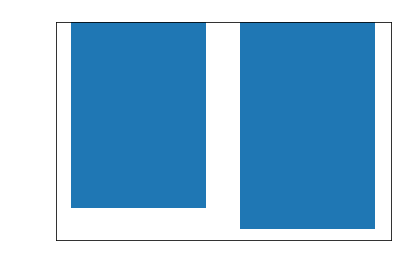

In [69]:
import matplotlib.pyplot as plt

# Define the data and labels for the plot
x_ticks = ['Correct Outline', 'Jumbled Outline']

# Create the bar chart
plt.bar(x_ticks, outline_iterations)

# Set the title and axis labels
plt.title('Logprobs Plot', color='white')
plt.xlabel('Outline Type', color='white')
plt.ylabel('Logprobs', color='white')

# Set the color of the frame, ticks and labels to white
frame = plt.gca()
frame.tick_params(axis='x', colors='white')
frame.tick_params(axis='y', colors='white')

# Show the plot
plt.show()

From this graph, we can see that changing the outline to a different order affects the logprob value negatively as compared to the logprob of the sentences when the outline order is correct.

Finally, let's see whether not including the outline in the prompt affects the logprob value.


We will use the original sentence order to test for this.

In [70]:
qwo_1 = '''
    Write a short essay
'''

We follow the same process of given our prompt with the paragraph to the API as a request to get a response which will be used to calculate the logprob.

In [71]:
result_outline = get_response(full_request_template(qwo_1, original_text))
result_outline


<OpenAIObject text_completion id=cmpl-6s61bK2GKrccVfyVua5Omvc0MClsA at 0x7fe1f8860cc0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": {
        "text_offset": [
          0,
          1,
          4,
          10,
          12,
          18,
          24,
          25,
          27,
          35,
          41,
          44,
          57,
          63,
          71,
          74,
          77,
          83,
          88,
          91,
          98,
          102,
          104,
          109,
          113,
          118,
          121,
          128,
          129,
          133,
          143,
          153,
          154,
          159,
          163,
          169,
          172,
          174,
          181,
          190,
          201,
          202,
          205,
          210,
          211,
          213,
          220,
          222,
          225,
          229,
          231,
          234,
          236,
          242,
    

After getting the response from the API, we then go on to calculate the logprob of the text (remember in this case we don't provide any outline to guide the logprob calculation).


In [72]:
original_text

'It started after my grandparents first brought me to their home in France and I have now been to twenty-nine different countries. Each has given me a unique learning experience. At five, I marveled at the Eiffel Tower in the City of Lights. When I was eight, I stood in the heart of Piazza San Marco feeding hordes of pigeons, then glided down Venetian waterways on sleek gondolas. At thirteen, I saw the ancient, megalithic structure of Stonehenge and walked along the Great Wall of China, amazed that the thousand-year-old stones were still in place. When I was very little, I caught the travel bug. '

In [73]:
logprob_3 = compute_log_probs(qwo_1, original_text, result_outline)
logprob_3

-212.26323597107597

Now that we have the logprob value, We are going to create a list to contain the logprob value we just found, and also append the logprob value of the corresponding sentence order paragraph but this time with the outline provided, to see the difference in logprobs.


In [74]:
prompt_iterations = []
prompt_iterations.append(logprobs_1[0])
prompt_iterations.append(logprob_3)

prompt_iterations

[-235.83677383316822, -212.26323597107597]

We now plot a graph for this list so that we can visally analyze our results.


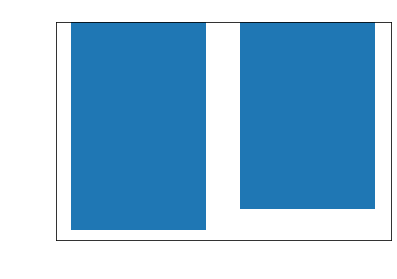

In [75]:
import matplotlib.pyplot as plt

# Define the data and labels for the plot
x_ticks = ['Prompt_w_Outline', 'Prompt_wo_Outline']

# Create the bar chart
plt.bar(x_ticks, prompt_iterations)

# Set the title and axis labels
plt.title('Logprobs Plot', color='white')
plt.xlabel('Outline Type', color='white')
plt.ylabel('Logprobs', color='white')

# Set the color of the frame, ticks and labels to white
frame = plt.gca()
frame.tick_params(axis='x', colors='white')
frame.tick_params(axis='y', colors='white')

# Show the plot
plt.show()

Looking at this graph, we can come to a steady conclusion that the outline arrangement and presence plays a role in the total logprob value which shows us that the prompt looks at the outline provided to assist in calculating the logprob values rather than just looking at the sentence cohesion of the paragraph given in the prompt.
